# Import utilities

In [1]:
import scipy

from MPO_utilities import *
from one_hot_basis import *

# Banded matrix

In [2]:
import numpy as np

def grid_banded(L: int,
                D: int,
                diag: complex = 0.0,
                hop: complex = 1.0,
                periodic: bool = False,
                sparse: bool = True,
                dtype=complex):
    """
    Nearest-neighbor banded matrix on a D-dimensional L^D hypercubic grid.

    Interpreted as the adjacency / hopping operator:
      H = diag * I + hop * sum_{mu=0}^{D-1} (I ⊗ ... ⊗ T ⊗ ... ⊗ I),
    where T is the 1D nearest-neighbor banded matrix with 1 on ±1 diagonals
    (and optional periodic wraparound).

    Parameters
    ----------
    L : int
        Linear size per dimension.
    D : int
        Dimension.
    diag : scalar
        On-site diagonal value.
    hop : scalar
        Nearest-neighbor coupling.
    periodic : bool
        If True, use periodic boundary conditions in each dimension.
    sparse : bool
        If True, return a scipy.sparse CSR matrix if scipy is available.
        If scipy isn't available (or sparse=False), returns a dense numpy array.
    dtype : numpy dtype
        Output dtype.

    Returns
    -------
    H : (L**D, L**D) sparse CSR matrix or dense ndarray
    """
    N = L**D
    if D < 1 or L < 1:
        raise ValueError("Require L >= 1 and D >= 1.")

    use_sparse = False
    sp = None
    if sparse:
        try:
            import scipy.sparse as sp  # type: ignore
            use_sparse = True
        except Exception:
            use_sparse = False

    # 1D nearest-neighbor banded operator T on length-L chain
    if use_sparse:
        e = np.ones(L - 1, dtype=dtype)
        T = sp.diags([hop * e, hop * e], offsets=[-1, 1], shape=(L, L), format="csr")
        if periodic and L > 1:
            T = T.tolil()
            T[0, L - 1] = hop
            T[L - 1, 0] = hop
            T = T.tocsr()
        I = sp.identity(L, dtype=dtype, format="csr")

        H = sp.identity(N, dtype=dtype, format="csr") * diag if diag != 0 else sp.csr_matrix((N, N), dtype=dtype)

        # Kronecker-sum construction
        for mu in range(D):
            op = None
            for ax in range(D):
                factor = T if ax == mu else I
                op = factor if op is None else sp.kron(op, factor, format="csr")
            H = H + op
        return H.tocsr()

    else:
        T = np.zeros((L, L), dtype=dtype)
        if L > 1:
            idx = np.arange(L - 1)
            T[idx, idx + 1] = hop
            T[idx + 1, idx] = hop
            if periodic:
                T[0, L - 1] = hop
                T[L - 1, 0] = hop
        I = np.eye(L, dtype=dtype)

        H = (diag * np.eye(N, dtype=dtype)) if diag != 0 else np.zeros((N, N), dtype=dtype)

        for mu in range(D):
            op = None
            for ax in range(D):
                factor = T if ax == mu else I
                op = factor if op is None else np.kron(op, factor)
            H = H + op
        return H

# Disordered potentials

In [3]:
def disorder_diagonal(D, n, q, W, disorder_type, seed=None):
    
    rng = np.random.default_rng(seed=seed)

    def Z_potential(bitstring):
        total = 0
        for i in range(len(bitstring)):
            Si = 1 - 2*int(bitstring[i])
            coeff = W*(2*rng.random()-1.)
            total += coeff * Si
        return total/np.sqrt(D*(q**n))

    def ZZ_potential(bitstring):
        total = 0
        for i in range(0, len(bitstring) - 1, 2):
            Si = 1 - 2*int(bitstring[i])
            Sip1 = 1 - 2*int(bitstring[i+1])
            coeff = W*(2*rng.random()-1.)
            total += coeff * Si * Sip1
        for i in range(1, len(bitstring) - 1, 2):
            Si = 1 - 2*int(bitstring[i])
            Sip1 = 1 - 2*int(bitstring[i+1])
            coeff = W*(2*rng.random()-1.)
            total += coeff * Si * Sip1
        return total/np.sqrt(D*(q**n-1))
    
    def uniform_random_potential(bitstring):
        return W*(2*rng.random()-1.)
    
    if disorder_type == "ZZ":
        disorder_potential = ZZ_potential
    elif disorder_type == "Z":
        disorder_potential = Z_potential
    elif disorder_type == "uniform_random":
        disorder_potential = uniform_random_potential

    basis_list = one_hot_bounce_bitstrings(n, q)
    L = len(basis_list)
    
    if D == 1:
        A = np.zeros(L)
        for i, x in enumerate(basis_list):
            A[i] = disorder_potential(x)
        return A

    elif D == 2:
        A = np.zeros((L, L))
        for i, x in enumerate(basis_list):
            for j, y in enumerate(basis_list):
                bs = x + y
                A[i, j] = disorder_potential(bs)

        return A.reshape(L**2)
    elif D == 3:
        A = np.zeros((L, L, L))
        for i, x in enumerate(basis_list):
            for j, y in enumerate(basis_list):
                for k, z in enumerate(basis_list):
                    bs = x + y + z
                    A[i, j, k] = disorder_potential(bs)
        
        return A.reshape(L**3)

In [4]:
q = 30
n = 1
V = disorder_diagonal(3, n, q, 1, "Z")
print(np.mean(V), np.max(V), np.min(V), np.std(V))

V = disorder_diagonal(3, n, q, 1, "ZZ")
print(np.mean(V), np.max(V), np.min(V), np.std(V))

V = disorder_diagonal(3, n, q, 1, "uniform_random")
print(np.mean(V), np.max(V), np.min(V), np.std(V))

0.0014621170496839624 2.326645237906058 -2.134487973044277 0.5759475644753457
-0.0015453727375507164 2.297088988222072 -2.256655874950835 0.5836110516193503
0.0032856568506741367 0.9999272287182326 -0.999929196086782 0.5765477527961875


# Return probability

In [9]:
from __future__ import annotations

import scipy.sparse as sp

import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Sequence, Tuple
 

def get_sparse_disorder_H(D, n, q, W, disorder_type="ZZ", seed=None):
    T = grid_banded(q**n, D)
    V = disorder_diagonal(D, n, q, W, disorder_type=disorder_type, seed=seed)
    return T + sp.diags(V, offsets=0, format="csr")

def _fmt_W(W) -> str:
    """Stable, filesystem-friendly formatting for W (float or int)."""
    if isinstance(W, (int, np.integer)):
        return str(int(W))
    # keep enough precision, avoid '.' issues in folder names
    s = f"{float(W):.12g}"
    return s.replace(".", "p").replace("-", "m")


def _eig_cache_path(
    D: int,
    n: int,
    q: int,
    W,
    disorder_type: str,
    seed: int,
    *,
    cache_root: str | Path = "Matrix",
    fname: str = "eig.npz",
) -> Path:
    #W_str = _fmt_W(W)
    return (
        Path(cache_root)
        / f"D={D}"
        / f"n={n}"
        / f"q={q}"
        / f"W={W}"
        / f"disorder_type={disorder_type}"
        / f"seed={seed}"
        / fname
    )

def _atomic_save_npz(path: Path, **arrays):
    """
    Atomically save a compressed .npz file.

    Guarantees:
    - No accidental '.npz' duplication
    - Final file name is exactly `path`
    """
    path = Path(path)
    assert path.suffix == ".npz", "Target file must end with .npz"

    path.parent.mkdir(parents=True, exist_ok=True)

    # TEMP FILE MUST ALSO END WITH .npz
    tmp = path.with_name(path.name + ".tmp.npz")

    np.savez_compressed(tmp, **arrays)

    # Atomic rename (POSIX-safe)
    os.replace(tmp, path)

def compute_or_load_eig(
    D: int,
    n: int,
    q: int,
    W,
    disorder_type: str = "ZZ",
    seed: int | None = None,
    save_to_disk: bool = True,
    load_if_exists: bool = True,
    cache_root: str | Path = "Matrix",
    cache_fname: str = "eig.npz",
):
    """
    Compute return probability R(t) = |<i0| exp(-i H t) |i0>|^2 for dense Hermitian H,
    where H is generated by get_H(D, n, q, W, disorder_type, seed).

    Caching:
      - if load_if_exists=True, tries to load eigendecomposition from disk first.
      - if save_to_disk=True, saves eigendecomposition (evals, evecs) to disk.
    """
    cache_path = _eig_cache_path(
        D, n, q, W, disorder_type, seed, cache_root=cache_root, fname=cache_fname
    )

    evals = evecs = None
    if load_if_exists and cache_path.exists() and (seed is not None):
        dat = np.load(cache_path, allow_pickle=False)
        evals = dat["evals"]
        evecs = dat["evecs"]
    
    if evals is None or evecs is None:
        H = get_sparse_disorder_H(D, n, q, W, disorder_type, seed)
        H = np.asarray(H)
        N = H.shape[0]
        assert H.shape == (N, N), "get_H must return a square (N,N) matrix"

        # Dense Hermitian eigendecomposition
        evals, evecs = np.linalg.eigh(H)

        if save_to_disk:
            _atomic_save_npz(cache_path, evals=evals, evecs=evecs)

    return evals, evecs


def compute_or_load_return_probability_dense(
    D: int,
    n: int,
    q: int,
    W,
    i0: int,
    times: np.ndarray,
    disorder_type: str = "ZZ",
    seed: int | None = None,
    save_to_disk: bool = True,
    load_if_exists: bool = True,
    cache_root: str | Path = "Matrix",
    cache_fname: str = "eig.npz",
):
    """
    Compute return probability R(t) = |<i0| exp(-i H t) |i0>|^2 for dense Hermitian H,
    where H is generated by get_H(D, n, q, W, disorder_type, seed).

    Caching:
      - if load_if_exists=True, tries to load eigendecomposition from disk first.
      - if save_to_disk=True, saves eigendecomposition (evals, evecs) to disk.
    """
    times = np.asarray(times, dtype=float)
    
    evals, evecs = compute_or_load_eig(D, n, q, W, 
                                       disorder_type=disorder_type,
                                       seed=seed,
                                       save_to_disk=save_to_disk,
                                       load_if_exists=load_if_exists,
                                       cache_root=cache_root,
                                       cache_fname=cache_fname)

    # weights w_n = |<n|i0>|^2 ; eigh returns eigenvectors as columns
    w = np.abs(np.conjugate(evecs[i0, :])) ** 2  # shape (N,)

    # amplitude A(t) = sum_n w_n exp(-i E_n t)
    phases = np.exp(-1j * np.outer(evals, times))  # (N,T)
    A = (w[:, None] * phases).sum(axis=0)          # (T,)
    R = np.abs(A) ** 2
    return R

def compute_return_probability_lanczos_sparse(
    D: int,
    n: int,
    q: int,
    W,
    i0: int,
    times: np.ndarray,
    disorder_type: str = "ZZ",
    seed: int | None = None,
):
    """
    Compute return probability R(t) = |<i0|exp(-i H t)|i0>|^2 using a single
    Lanczos tridiagonalization starting from |i0>, with H given as a sparse matrix.

    Assumptions:
      - H is Hermitian (real-symmetric is fine).
      - i0 is a basis index in [0, N).

    Notes:
      - This builds a Krylov subspace of size m (chosen heuristically) and then
        evaluates a(t)=e1^T exp(-i T_m t) e1 cheaply for all times.
    """
    times = np.asarray(times, dtype=float)
    if times.ndim != 1:
        raise ValueError("times must be a 1D array.")
    if times.size == 0:
        return np.array([], dtype=float)

    # Build sparse Hamiltonian
    H = get_sparse_disorder_H(D, n, q, W, disorder_type, seed)
    if not sp.issparse(H):
        raise TypeError("get_H must return a scipy.sparse matrix.")
    if H.shape[0] != H.shape[1]:
        raise ValueError("H must be square.")
    N = H.shape[0]
    if not (0 <= i0 < N):
        raise ValueError(f"i0 must be in [0, {N}), got {i0}.")

    # Ensure CSR for fast matvec
    H = H.tocsr()

    # Heuristic choice of Krylov dimension m:
    # - Larger t_max typically needs larger m.
    # - Keep it modest by default; you can edit these constants if needed.
    t_max = float(np.max(times))
    # Cheap norm proxy: max row sum (infinity norm upper bound)
    # (works for real/complex sparse)
    absH = abs(H)
    row_sum = np.asarray(absH.sum(axis=1)).ravel()
    H_norm_inf = float(row_sum.max()) if row_sum.size else 0.0

    # Basic heuristic: m ~ O(t_max * ||H||) but capped
    # (the constants are conservative; adjust if needed)
    m_guess = int(np.clip(20 + 0.6 * t_max * max(1.0, H_norm_inf), 40, 240))
    m = min(m_guess, N)

    # Lanczos tridiagonalization (no full reorth; good for this observable)
    alpha = np.zeros(m, dtype=np.float64)
    beta = np.zeros(max(0, m - 1), dtype=np.float64)

    v_prev = np.zeros(N, dtype=np.complex128)
    v = np.zeros(N, dtype=np.complex128)
    v[i0] = 1.0  # |i0>

    # main loop
    # We allow "happy breakdown" if beta becomes ~0
    for j in range(m):
        w = H @ v  # sparse matvec
        aj = np.vdot(v, w).real  # should be real if H Hermitian
        alpha[j] = aj

        # w <- w - aj v - beta_{j-1} v_prev
        if j == 0:
            w = w - aj * v
        else:
            w = w - aj * v - beta[j - 1] * v_prev

        bj = np.linalg.norm(w)
        if j < m - 1:
            beta[j] = bj

        if bj < 1e-14:
            # Krylov subspace closed early
            alpha = alpha[: j + 1]
            beta = beta[: j]
            break

        v_prev, v = v, (w / bj)

    # Build T_m and diagonalize
    m_eff = alpha.size
    if m_eff == 1:
        # T = [alpha0] -> a(t)=exp(-i alpha0 t)
        a_t = np.exp(-1j * alpha[0] * times)
        return np.abs(a_t) ** 2

    T = np.diag(alpha)
    if beta.size:
        T += np.diag(beta, 1) + np.diag(beta, -1)

    # T is real symmetric
    lam, S = np.linalg.eigh(T)
    wts = (S[0, :] ** 2)  # = |S_{1k}|^2, nonnegative, sums to 1

    # a(t) = sum_k w_k exp(-i lam_k t)
    phase = np.exp(-1j * np.outer(lam, times))  # (m_eff, nt)
    a_t = (wts[:, None] * phase).sum(axis=0)
    R_t = np.abs(a_t) ** 2
    return R_t

@dataclass
class LocalizationSweep:
    D: int
    pairs: list[tuple[int, int]]      # [(q,n), ...]
    Ls: np.ndarray                    # L = q**n for each pair
    Ws: np.ndarray
    Rbar: np.ndarray                  # (nW, nPairs)
    Rbar_err: np.ndarray              # (nW, nPairs)
    Y: np.ndarray                     # (nW, nPairs) = L^D * Rbar
    Y_err: np.ndarray

def time_average(times: np.ndarray, values: np.ndarray, t1: float, t2: float) -> float:
    mask = (times >= t1) & (times <= t2)
    if mask.sum() < 2:
        raise ValueError("Need >=2 time points in [t1, t2].")
    return np.trapezoid(values[mask], times[mask]) / (times[mask][-1] - times[mask][0])

def sweep_localization_transition(
    *,
    D: int,
    pairs: Sequence[Tuple[int, int]],     # [(q,n), ...]
    Ws: Sequence[float],
    times: np.ndarray,
    n_disorder: int = 50,
    time_window: Tuple[float, float] | None = None,
    init_state_type = "center",
    disorder_type: str = "ZZ",
    base_seed: int = 1234,

    algorithm: str = "sparse_lanczos",
    cache_root: str | Path = "Matrix",
    save_to_disk: bool = True,
    load_if_exists: bool = True,
):
    pairs = [(int(q), int(n)) for (q, n) in pairs]
    Ws = np.asarray(Ws, dtype=float)
    times = np.asarray(times, dtype=float)

    Ls = np.array([q**n for (q, n) in pairs], dtype=int)

    Rbar = np.zeros((len(Ws), len(pairs)), dtype=float)
    Rbar_err = np.zeros_like(Rbar)

    for iW, W in enumerate(Ws):
        for ip, (q, n) in enumerate(pairs):
            samples = np.empty(n_disorder, dtype=float)

            L = Ls[ip]
            if init_state_type == "center":
                i0 = L//2
                for d in range(1, D):
                    i0 = (L//2) * (L**d)
            else:
                raise NotImplementedError

            for s in range(n_disorder):
                #seed = base_seed + 10_000*iW + 1_000*ip + s
                seed = np.random.SeedSequence([base_seed, iW, ip, s]).generate_state(1, dtype=np.uint32)[0]

                if algorithm == "dense":
                    R_t = compute_or_load_return_probability_dense(
                        D=D,
                        n=n,
                        q=q,
                        W=W,
                        i0=int(i0),
                        times=times,
                        disorder_type=disorder_type,
                        seed=int(seed),
                        save_to_disk=save_to_disk,
                        load_if_exists=load_if_exists,
                        cache_root=cache_root,
                    )
                elif algorithm == "sparse_lanczos":
                    R_t = compute_return_probability_lanczos_sparse(
                        D=D,
                        n=n,
                        q=q,
                        W=W,
                        i0=int(i0),
                        times=times,
                        disorder_type=disorder_type,
                        seed=int(seed),)
                else:
                    raise NotImplementedError

                if time_window is None:
                    t1 = 20
                    t2 = 3*L
                else:
                    t1, t2 = time_window
                samples[s] = time_average(times, np.asarray(R_t, float), t1, t2)

            Rbar[iW, ip] = samples.mean()
            Rbar_err[iW, ip] = samples.std(ddof=1) / np.sqrt(n_disorder)

            L = Ls[ip]
            print(
                f"W={W:6.2f}, (q,n)=({q},{n}), L=q^n={L:6d} | "
                f"R̄={Rbar[iW,ip]:.4e} ± {Rbar_err[iW,ip]:.1e}"
            )

    N = (Ls.astype(float) ** D)[None, :]
    Y = N * Rbar
    Y_err = N * Rbar_err

    return LocalizationSweep(
        D=D, pairs=list(pairs), Ls=Ls, Ws=Ws,
        Rbar=Rbar, Rbar_err=Rbar_err,
        Y=Y, Y_err=Y_err,
    )

def plot_return_crossing(sweep: LocalizationSweep, *, ax=None, with_errorbars=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5.4, 4.0))

    for ip, ((q, n), L) in enumerate(zip(sweep.pairs, sweep.Ls)):
        y = sweep.Y[:, ip]
        yerr = sweep.Y_err[:, ip]
        label = fr"$(q,n)=({q},{n}),\ L={q}^{{{n}}}={L}$"

        if with_errorbars:
            ax.errorbar(sweep.Ws, y, yerr=yerr, marker="o", capsize=3, label=label)
        else:
            ax.plot(sweep.Ws, y, marker="o", label=label)

    ax.set_xlabel("Disorder strength $W$")
    ax.set_ylabel(r"$L^{D}\,\overline{R}$")
    ax.legend(frameon=False)
    ax.grid(alpha=0.25)
    return ax


'''
def return_probability_input_eig(evals, evecs, i0, times):

    # weights w_n = |<n|i0>|^2
    w = np.abs(np.conjugate(evecs[i0, :]))**2

    # amplitude A(t) = sum_n w_n exp(-i E_n t)
    phases = np.exp(-1j * np.outer(evals, times))   # (N,T)
    A = (w[:, None] * phases).sum(axis=0)           # (T,)
    return np.abs(A)**2


def plot_return_probability(times, R, title="Return probability", log_scale=False):
    """
    Plot a single return-probability curve.

    Parameters
    ----------
    times : (T,) array
    R     : (T,) array
    title : str
    log_scale : bool
        If True, use log scale on y-axis.
    """
    times = np.asarray(times, dtype=float)
    R = np.asarray(R)

    fig, ax = plt.subplots()
    ax.plot(times, R)
    ax.set_xlabel("t")
    ax.set_ylabel(r"$R(t)=|\langle \psi(0) | \psi(t)\rangle|^2$")
    ax.set_title(title)
    if log_scale:
        ax.set_yscale("log")
    else:
        ax.set_ylim(-0.02, 1.02)
    ax.grid(True, which="both", alpha=0.3)
    return fig, ax


def plot_return_probability_vs_W(
    D: int,
    n: int,
    q: int,
    W_list,
    i0: int,
    times: np.ndarray,
    seed_list,
    
    feature_to_plot="alpha_eff",
    get_H=get_H,  # get_H(D, n, q, W, disorder_type, seed) -> H
    disorder_type: str = "ZZ",
    x_log_scale: bool = True,
    y_log_scale: bool = False,
    save_to_disk: bool = True,
    load_if_exists: bool = True,
    cache_root: str = "Matrix",
    cache_fname: str = "eig.npz",
    title: str | None = None,
):
    """
    Joint plot of return probability for a list of disorder strengths W_list.

    Uses return_probability_dense(D,n,q,W,disorder_type,seed,...) which
    internally calls get_H and optionally caches eigendecompositions.
    """

    def alpha_from_logR(times, logR_avg, smooth_window=0):
        """
        Compute alpha(t) = - d <log R> / d log t

        Parameters
        ----------
        times : (T,) array, t > 0
        logR_avg : (T,) array, <log R(t)>
        smooth_window : int, optional odd integer for smoothing logR before derivative

        Returns
        -------
        alpha : (T,) array
        """
        t = np.asarray(times, dtype=float)
        logt = np.log(t)

        logR = np.asarray(logR_avg, dtype=float)

        if smooth_window and smooth_window > 1:
            if smooth_window % 2 == 0:
                raise ValueError("smooth_window must be odd")
            kernel = np.ones(smooth_window) / smooth_window
            logR = np.convolve(logR, kernel, mode="same")

        alpha = -np.gradient(logR, logt)
        return alpha

    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(W_list)))

    for W, c in zip(W_list, colors):
        #R_avg = 0
        R_list = []
        for seed in seed_list:
            R = compute_or_load_return_probability(
                D=D, n=n, q=q, W=W, disorder_type=disorder_type, seed=seed,
                i0=i0, times=times,
                get_H=get_H,
                save_to_disk=save_to_disk,
                load_if_exists=load_if_exists,
                cache_root=cache_root,
                cache_fname=cache_fname,
            )
            R_list.append(R)
        if feature_to_plot == "R":
            R_avg = np.mean(R_list, axis=0)
            label = f"W={W}"
            ax.plot(times, R_avg, color=c, label=label)
        elif feature_to_plot == "alpha_eff":
            eps = 1e-300
            logR_avg = np.mean(np.log(np.maximum(R_list, eps)), axis=0)

            # optional: enforce monotone decay envelope for cleanliness
            logR_avg = np.minimum.accumulate(logR_avg)

            alpha = alpha_from_logR(times, logR_avg, smooth_window=0)
            ax.plot(times, alpha, color=c, label=f"W={W}")

    ax.set_xlabel("t")
    ax.set_ylabel(f"{feature_to_plot}")
    if x_log_scale:
        ax.set_xscale("log")
    if y_log_scale:
        ax.set_yscale("log")
    ax.set_title(title or f"{feature_to_plot} vs disorder strength (D={D}, n={n}, q={q})")
    ax.legend()
    ax.grid(True, which="both", alpha=0.3)
    return fig, ax
'''


'\ndef return_probability_input_eig(evals, evecs, i0, times):\n\n    # weights w_n = |<n|i0>|^2\n    w = np.abs(np.conjugate(evecs[i0, :]))**2\n\n    # amplitude A(t) = sum_n w_n exp(-i E_n t)\n    phases = np.exp(-1j * np.outer(evals, times))   # (N,T)\n    A = (w[:, None] * phases).sum(axis=0)           # (T,)\n    return np.abs(A)**2\n\n\ndef plot_return_probability(times, R, title="Return probability", log_scale=False):\n    """\n    Plot a single return-probability curve.\n\n    Parameters\n    ----------\n    times : (T,) array\n    R     : (T,) array\n    title : str\n    log_scale : bool\n        If True, use log scale on y-axis.\n    """\n    times = np.asarray(times, dtype=float)\n    R = np.asarray(R)\n\n    fig, ax = plt.subplots()\n    ax.plot(times, R)\n    ax.set_xlabel("t")\n    ax.set_ylabel(r"$R(t)=|\\langle \\psi(0) | \\psi(t)\rangle|^2$")\n    ax.set_title(title)\n    if log_scale:\n        ax.set_yscale("log")\n    else:\n        ax.set_ylim(-0.02, 1.02)\n    ax.gr

## Sparse Lanczos

W=  2.00, (q,n)=(6,2), L=q^n=    36 | R̄=1.0676e-02 ± 9.2e-05
W=  2.00, (q,n)=(7,2), L=q^n=    49 | R̄=7.3943e-03 ± 4.6e-05
W=  2.00, (q,n)=(8,2), L=q^n=    64 | R̄=1.0417e-02 ± 4.7e-05
W=  4.00, (q,n)=(6,2), L=q^n=    36 | R̄=1.4581e-02 ± 5.1e-04
W=  4.00, (q,n)=(7,2), L=q^n=    49 | R̄=1.0329e-02 ± 2.8e-04
W=  4.00, (q,n)=(8,2), L=q^n=    64 | R̄=1.2972e-02 ± 2.1e-04
W=  6.00, (q,n)=(6,2), L=q^n=    36 | R̄=2.7338e-02 ± 2.0e-03
W=  6.00, (q,n)=(7,2), L=q^n=    49 | R̄=3.8797e-02 ± 9.8e-03
W=  6.00, (q,n)=(8,2), L=q^n=    64 | R̄=3.6303e-02 ± 1.5e-02
W=  8.00, (q,n)=(6,2), L=q^n=    36 | R̄=1.0162e-01 ± 2.2e-02
W=  8.00, (q,n)=(7,2), L=q^n=    49 | R̄=5.7155e-02 ± 1.4e-02
W=  8.00, (q,n)=(8,2), L=q^n=    64 | R̄=5.6603e-02 ± 1.1e-02
W= 10.00, (q,n)=(6,2), L=q^n=    36 | R̄=1.2606e-01 ± 2.8e-02
W= 10.00, (q,n)=(7,2), L=q^n=    49 | R̄=1.0820e-01 ± 1.5e-02
W= 10.00, (q,n)=(8,2), L=q^n=    64 | R̄=6.5243e-02 ± 6.8e-03
W= 12.00, (q,n)=(6,2), L=q^n=    36 | R̄=1.5471e-01 ± 1.7e-02
W= 12.00

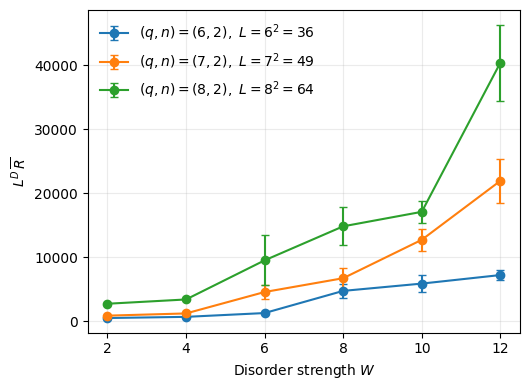

In [27]:
D = 3
qn_pairs = [(6, 2), (7, 2), (8, 2)]
Ws = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0]
times = np.arange(0, 250, step=0.01) #np.linspace(0.0, 250.0, 501)

res = sweep_localization_transition(
    D=D, pairs=qn_pairs, Ws=Ws, times=times, base_seed=1234,
    n_disorder=50, algorithm = "sparse_lanczos", disorder_type="ZZ"
)
 
plot_return_crossing(res)
plt.tight_layout()
plt.show()

In [337]:
np.arange(10, 20, step=0.5)

array([10. , 10.5, 11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. ,
       15.5, 16. , 16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5])

## Test 2

In [266]:
seed_list = []
for _ in range(20): 
    seed_list.append(int(np.random.SeedSequence().entropy))

C:\Users\Jielun\AppData\Local\Temp\ipykernel_290116\58236415.py:239: RuntimeWarning: divide by zero encountered in log
  logt = np.log(t)
c:\Users\Jielun\Documents\GitHub\one_hot_QTT\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
c:\Users\Jielun\Documents\GitHub\one_hot_QTT\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:1311: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'alpha_eff vs disorder strength (D=3, n=3, q=2)'}, xlabel='t', ylabel='alpha_eff'>)

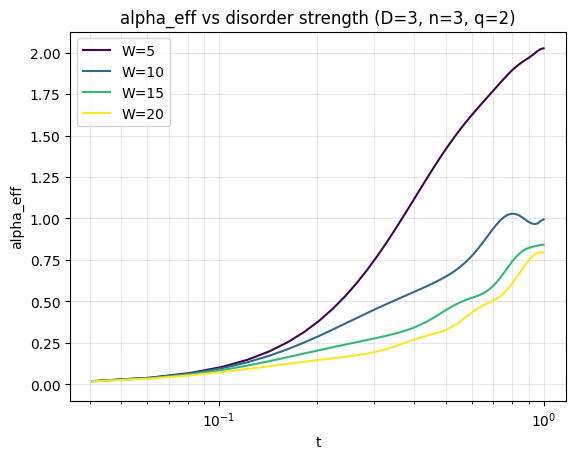

In [ ]:
D = 3
nq_pairs = 

L = q**n
i0 = L//2
for d in range(1, D):
    i0 = (L//2) * (L**d)

W_list = [5, 10, 15, 20]
times = np.linspace(0.0, 1, 50)
#plot_return_probability_vs_W(D, q, n, W_list, i0, times, seed_list, disorder_type="uniform_random", x_log_scale=True)

In [257]:
import numpy as np

master_seed = 123456
ss = np.random.SeedSequence(master_seed)

n = 100
child_ss = ss.spawn(n)

# one 128-bit-ish integer per child (from 4x uint32)
seeds = [tuple(s.generate_state(4)) for s in child_ss]  # portable representation
# or convert to a single Python int:
seeds_int = [int(np.uint64(st[0]) | (np.uint64(st[1])<<32)) for st in seeds]  # 64-bit

In [258]:
seeds_int

[16911510738685935955,
 9783031064211771352,
 979552095395381530,
 12974264437358835387,
 17792438216852205868,
 7633496370941834573,
 5045725808062066884,
 14947913283845412614,
 12090641933656064760,
 15199375088586648540,
 14898045832595667087,
 7141634041135794041,
 15796213180635541267,
 4764439428695249377,
 2664715293675150140,
 5635445525123769662,
 1696068373077408244,
 12914463438571386121,
 2944864516253573852,
 17159476616274503499,
 1473530770736294574,
 16986376783580134504,
 11151533457674324901,
 11436644677240310816,
 12762742401450743763,
 11903378187082422341,
 11063949795971171106,
 15081526804933844998,
 11837612947348385534,
 7981910885208476491,
 49054709909253993,
 5479388343897827248,
 6734965265496833616,
 8464266917985493403,
 11606498623419540180,
 15962425760253934399,
 2217661303682839634,
 3256102987036778829,
 5009219599288680683,
 13285932619903760518,
 12621932118672347729,
 14961740267261505670,
 4325071548811449018,
 15532989674021244179,
 1192360845